<a href="https://colab.research.google.com/github/imnotsoumyajit/Mental-Health-Analysis/blob/master/sentimental_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost xgboost lightgbm wordcloud textblob

In [ ]:
import pandas as pd
import numpy as np
import string

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 55)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
df=pd.read_csv('/content/Combined Data.csv')
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [ ]:
df['statement'] = df['statement'].fillna('')

In [ ]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
df.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [ ]:
df["status"].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [ ]:
df[df["status"] == "Anxiety"]["statement"][1]

'trouble sleeping, confused mind, restless heart. All out of tune'

In [ ]:
df["status"] = df["status"].map({'Anxiety':0, 'Normal':1, 'Depression':2, 'Suicidal':3, 'Stress':4, "Bipolar": 5, "Personality disorder": 6})

In [ ]:
def clean_text(text):
    # Normalizing Case Folding
    text = text.str.lower()
    text = text.str.replace(r'[^\w\s]', '', regex = True)
    text = text.str.replace("\n" , '', regex = True)
    text = text.str.replace('\d', '', regex = True)
    text = text.str.replace(r'\[.*?\]', '', regex = True)
    text = text.str.replace(r'https?://\S+|www\.\S+', '', regex = True)
    text = text.str.replace(r'<.*?>+', '', regex = True)
    text = text.str.replace(r'\w*\d\w*', '', regex = True)
    return text

In [ ]:
df["statement"] = clean_text(df["statement"])

In [ ]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))
    return text

In [ ]:
import nltk
nltk.download("stopwords")
df["statement"] = remove_stopwords(df["statement"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
delete = pd.Series(' '.join(df['statement']).split()).value_counts()[-1000:]
df['statement'] = df['statement'].apply(lambda x: " ".join(x for x in x.split() if x not in delete))

In [ ]:
nlp = spacy.load('en_core_web_sm')

def lemmatize_sentence(sentence):
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc])

In [ ]:
df['statement'] = df['statement'].apply(lemmatize_sentence)

In [ ]:
df.head()

,statement,status
0,oh gosh,0
1,trouble sleep confused mind restless heart tune,0
2,wrong back dear forward doubt stay restless re...,0
3,I ve shift focus something else I m still worried,0
4,I m restless restless month boy mean,0


In [ ]:
df.isnull().sum()

,0
statement,0
status,0


In [ ]:
y = df['status']
X = df.drop('status', axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X_train

,statement
32560,get
22775,come awful start lose year relationship family...
44021,need inspiration hit kitchen tonight
20262,possible communicate text suicidal feel like s...
13631,literally get call wierd internet friend group...
...,...
11284,use confident cheerful person today become awk...
44732,spanx except miss last week lee go iplayer
38158,tl dr abuse mentally physically parent through...
860,sell tutorial


In [ ]:
def plot_wordcloud(text, title=None, save_path=None):
    wordcloud = WordCloud(width=800, height=400, colormap = 'BuPu_r',
                          background_color='white',
                          contour_width=3, contour_color='black').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=20)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

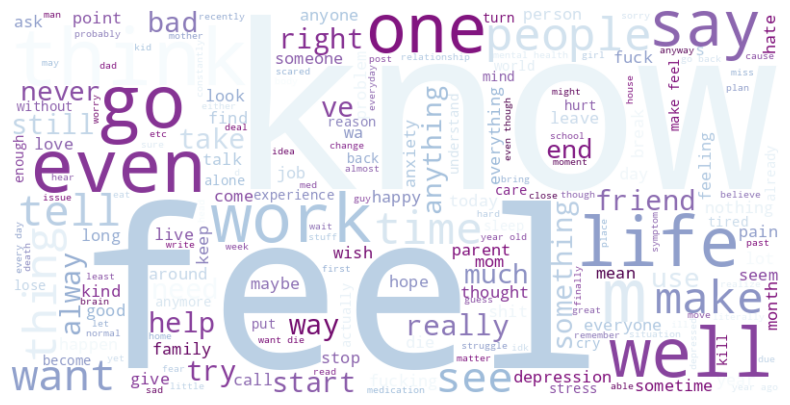

In [ ]:
all_text = ' '.join(X_train['statement'])
plot_wordcloud(all_text)

In [ ]:
y.unique().tolist()

[0, 1, 2, 3, 4, 5, 6]

In [ ]:
def count_vec_boost(model, text_col, max_df, max_features, ngram_range, n_estimators, max_depth=3, learning_rate=0.03, verbose = False):
    """
    Vectorizes text data using CountVectorizer, trains a classifier model, and evaluates its performance.

    Parameters:
    - model: Classifier model (e.g., XGBoostClassifier, LightGBMClassifier, CatBoostClassifier)
    - text_col: Name of the text column in the dataset
    - max_df: Maximum document frequency threshold for CountVectorizer
    - max_features: Maximum number of features for CountVectorizer
    - ngram_range: Tuple specifying the range of n-grams (e.g., (1, 2) for unigrams and bigrams)
    - stop_words: List of stop words to be removed during vectorization
    - n_estimators: Number of estimators for the classifier model
    - max_depth: Maximum depth of the decision trees (if applicable)
    - learning_rate: Learning rate for gradient boosting classifiers (if applicable)

    Returns:
    - None

    Prints:
    - Classification report showing precision, recall, and F1-score for each class.
    - Confusion matrix visualizing predicted vs. true labels.

    Example usage:
    ```
    vec_pred(RandomForestClassifier, 'text_column', max_df=0.8, max_features=1000, ngram_range=(1, 2),
             stop_words=['english'], n_estimators=100, max_depth=10)
    ```

    """
    best_vectorizer = CountVectorizer(max_df=max_df, max_features=max_features, ngram_range=ngram_range)
    X_train_vector = best_vectorizer.fit_transform(X_train[text_col])
    best_classifier = model(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    best_classifier.fit(X_train_vector, y_train)
    X_test_vector = best_vectorizer.transform(X_test[text_col])
    y_pred = best_classifier.predict(X_test_vector)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    class_labels = y.unique().tolist()
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def tfidf_vec_boost(model, text_col, max_df, max_features, ngram_range, n_estimators, max_depth=3, learning_rate=0.03, verbose = False):
    """
    Vectorizes text data using TfidfVectorizer, trains a classifier model, and evaluates its performance.

    Parameters:
    - model: Classifier model (e.g., XGBoostClassifier, LightGBMClassifier, CatBoostClassifier)
    - text_col: Name of the text column in the dataset
    - max_df: Maximum document frequency threshold for TfidfVectorizer
    - max_features: Maximum number of features for TfidfVectorizer
    - ngram_range: Tuple specifying the range of n-grams (e.g., (1, 2) for unigrams and bigrams)
    - stop_words: List of stop words to be removed during vectorization
    - n_estimators: Number of estimators for the classifier model
    - max_depth: Maximum depth of the decision trees (if applicable)
    - learning_rate: Learning rate for gradient boosting classifiers (if applicable)

    Returns:
    - None

    Prints:
    - Classification report showing precision, recall, and F1-score for each class.
    - Confusion matrix visualizing predicted vs. true labels.

    Example usage:
    ```
    vec_boost_tfidf(RandomForestClassifier, 'text_column', max_df=0.8, max_features=1000, ngram_range=(1, 2),
                    stop_words=['english'], n_estimators=100, max_depth=10)
    ```
    """
    # Vectorize text data using TfidfVectorizer
    best_vectorizer = TfidfVectorizer(max_df=max_df, max_features=max_features, ngram_range=ngram_range)
    X_train_vector = best_vectorizer.fit_transform(X_train[text_col])

    # Initialize and train the classifier model
    best_classifier = model(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, verbose = verbose)
    best_classifier.fit(X_train_vector, y_train)

    # Transform test data using the trained vectorizer
    X_test_vector = best_vectorizer.transform(X_test[text_col])

    # Predict test labels
    y_pred = best_classifier.predict(X_test_vector)

    # Print classification report
    print(classification_report(y_test, y_pred))

    # Compute and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    class_labels = y_test.unique().tolist()
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def pipe_boosting(vectorizer, classifier, X_grid, y_grid):
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])

    hyperparameters = {
        'vectorizer__ngram_range': [(1, 3)],
        'vectorizer__max_df': [1.0],
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate':[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]}

    grid_search = GridSearchCV(pipeline, hyperparameters, cv=5, n_jobs=-1, verbose=1)

    grid_search.fit(X_grid, y_grid)

    print("Best hyperparameters:", grid_search.best_params_)

In [ ]:
def predict_new_text(text, c_vectorizer, model):
    """
    Predicts the category of a given text using the trained vectorizer and model.

    Parameters:
    - text: The input text to be classified
    - c_vectorizer: The trained CountVectorizer or TfidfVectorizer
    - model: The trained classification model

    Returns:
    - dict: The predicted category label and its corresponding index
    """
    # Define the mapping of indices to category labels
    label_mapping = {
        0: 'Anxiety',
        1: 'Normal',
        2: 'Depression',
        3: 'Suicidal',
        4: 'Stress',
        5: 'Bipolar',
        6: 'Personality disorder'
    }

    # Transform the input text using the vectorizer
    text_vector = c_vectorizer.transform([text])

    # Predict the category index
    predicted_index = model.predict(text_vector)[0]

    # Map the predicted index to the category label
    predicted_label = label_mapping[predicted_index]

    return {predicted_label: predicted_index}

In [ ]:
"""%%time
pipe_boosting(vectorizer = CountVectorizer(),
classifier = XGBClassifier(verbose = -1),
X_grid = X_train['statement'],
y_grid = y_train)"""

"%%time\npipe_boosting(vectorizer = CountVectorizer(),\nclassifier = XGBClassifier(verbose = -1),\nX_grid = X_train['statement'],\ny_grid = y_train)"

In [ ]:
best_hyperparameters = {'learning_rate': 0.07, 'n_estimators': 200, 'max_df': 1.0, 'max_features': 10000, 'ngram_range': (1, 3)}

              precision    recall  f1-score   support

           0       0.75      0.63      0.69       966
           1       0.75      0.96      0.84      4154
           2       0.70      0.68      0.69      3860
           3       0.66      0.58      0.62      2572
           4       0.69      0.38      0.49       697
           5       0.87      0.65      0.75       711
           6       0.90      0.42      0.57       301

    accuracy                           0.72     13261
   macro avg       0.76      0.62      0.66     13261
weighted avg       0.72      0.72      0.71     13261



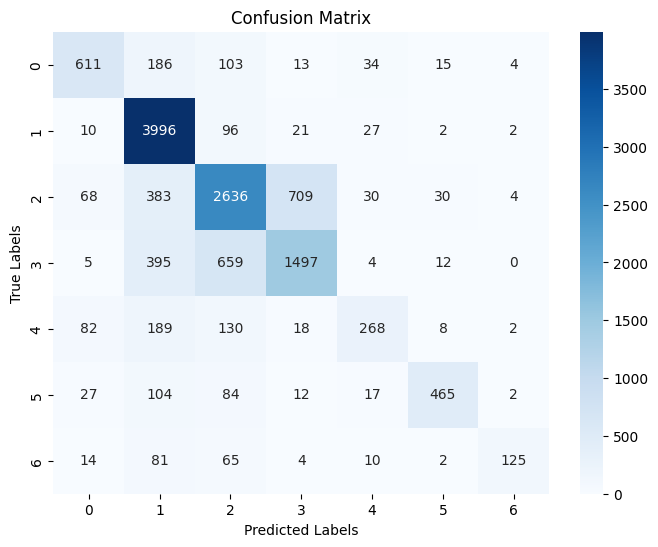

In [ ]:
count_vec_boost(XGBClassifier, "statement", **best_hyperparameters, verbose = False)

In [ ]:
c_vectorizer = CountVectorizer(max_df = 1.0, max_features = 2000, ngram_range = (1, 3))
X_train_vector = c_vectorizer.fit_transform(X_train['statement'])
X_test_vector = c_vectorizer.transform(X_test['statement'])

In [ ]:
model = XGBClassifier(**best_hyperparameters)
model.fit(X_train_vector, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_df=1.0,
              max_features=10000, max_leaves=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=200, n_jobs=None, ...)

In [ ]:
text = df["statement"].sample(1)
text_index = text.index
print(text.index)
text = text.values[0]
text

Index([2324], dtype='int64')


'btw vaccine cancel fast vaccine schedule today'

In [ ]:
predict_new_text(text,c_vectorizer, model)

{'Normal': 1}

In [ ]:
df.loc[text_index]["status"]

,status
2324,1


              precision    recall  f1-score   support

           0       0.79      0.72      0.75       966
           1       0.80      0.95      0.87      4154
           2       0.71      0.70      0.71      3860
           3       0.66      0.62      0.64      2572
           4       0.65      0.47      0.55       697
           5       0.86      0.69      0.77       711
           6       0.86      0.45      0.59       301

    accuracy                           0.75     13261
   macro avg       0.76      0.66      0.70     13261
weighted avg       0.74      0.75      0.74     13261



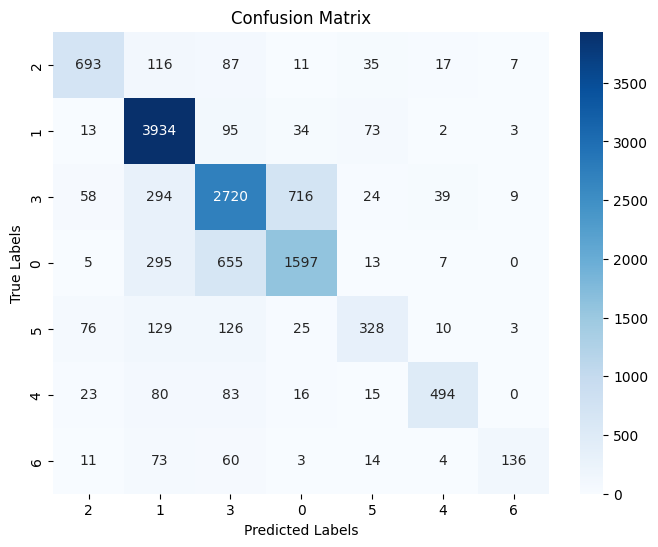

In [ ]:
tfidf_vec_boost(XGBClassifier, "statement", 1.0, 2000, (1, 3), 200, 5, 0.07, verbose = False)

In [ ]:
"""%%time
pipe_boosting(vectorizer = TfidfVectorizer(),
classifier = LGBMClassifier(force_col_wise=True, verbose = -1),
X_grid = X_train['statement'],
y_grid = y_train)"""

"%%time\npipe_boosting(vectorizer = TfidfVectorizer(),\nclassifier = LGBMClassifier(force_col_wise=True, verbose = -1),\nX_grid = X_train['statement'],\ny_grid = y_train)"

In [ ]:
best_params = {'learning_rate': 0.06, 'n_estimators': 200, 'max_df': 1.0, 'max_features': 2000, 'ngram_range': (1, 3)}

              precision    recall  f1-score   support

           0       0.78      0.70      0.74       966
           1       0.78      0.96      0.86      4154
           2       0.71      0.70      0.70      3860
           3       0.67      0.60      0.63      2572
           4       0.67      0.45      0.54       697
           5       0.85      0.67      0.75       711
           6       0.85      0.44      0.58       301

    accuracy                           0.74     13261
   macro avg       0.76      0.64      0.69     13261
weighted avg       0.74      0.74      0.73     13261



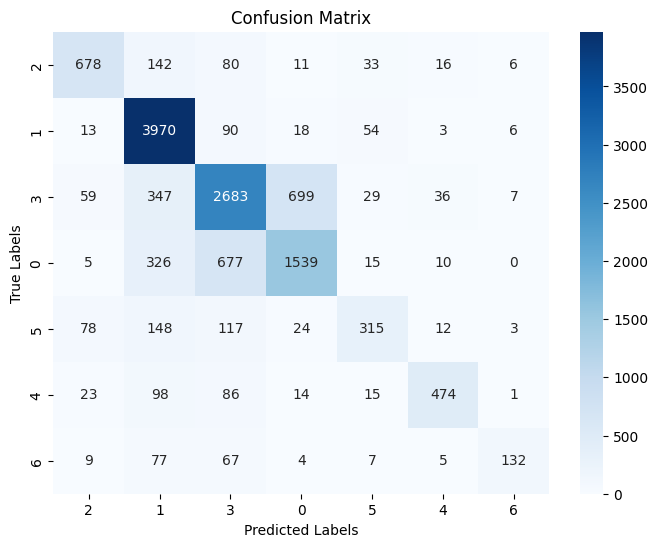

In [ ]:
tfidf_vec_boost(LGBMClassifier, "statement", **best_params, verbose = -1)

In [ ]:
model = XGBClassifier(**best_hyperparameters, verbose = False)
model.fit(X_train_vector, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_df=1.0,
              max_features=10000, max_leaves=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=200, n_jobs=None, ...)

In [ ]:
"""text = df["statement"].sample(1)
text_index = text.index
print(text.index)
text = text.values[0]
text"""

'text = df["statement"].sample(1)\ntext_index = text.index\nprint(text.index)\ntext = text.values[0]\ntext'

In [ ]:
predict_new_text(text, c_vectorizer, model)

{'Normal': 1}

In [ ]:
df.loc[text_index]["status"]

,status
2324,1


In [ ]:
import joblib

# Save the model to a file
joblib.dump(model, 'xgb_model.pkl')

['xgb_model.pkl']

In [ ]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the saved model
loaded_model = joblib.load('xgb_model.pkl')

# Assuming you have the original vectorizer or can recreate it with the same parameters
vectorizer = TfidfVectorizer(max_df=1.0, max_features=2000, ngram_range=(1, 3))

# Fit the vectorizer to the training data (replace X_train with your actual training data)
vectorizer.fit(X_train)

# Preprocess the new text
new_text = "I'm feeling really down and anxious lately."
stop_words = set(stopwords.words('english'))
preprocessed_text = ' '.join([word for word in new_text.lower().split() if word not in stop_words])

# Transform the new text using the fitted vectorizer
new_text_vector = vectorizer.transform([preprocessed_text])

# Reshape the new text vector to match the expected input shape (if necessary)
new_text_vector = new_text_vector.reshape(1, -1)

# Make the prediction
predicted_label = loaded_model.predict(new_text_vector)[0]

print(predicted_label)

ValueError: Feature shape mismatch, expected: 2000, got 1